# Topic modelling using BERTopic

## Libraries/data required

In [13]:
# IMPORTS
from bertopic import BERTopic
import pandas as pd
import os

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk import WordNetLemmatizer
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20203697\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20203697\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\20203697\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\20203697\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [14]:
# Read the data and perform preprocessing

df = pd.read_csv("data/articles_summary_cleaned.csv", parse_dates=["date"]) # Read data into 'df' dataframe
print(df.shape) # Print dataframe shape

docs = df["summary"].tolist() # Create a list containing all article summaries

df.head() # Show first 5 dataframe entries

(18520, 5)


,summary,date,location_article,lat,lng
0,The article discusses the passing of the new C...,2011-07-07,Juba,4.859363,31.571250
1,The article discusses the military actions tak...,2011-07-03,Abyei,9.838551,28.486396
2,The article discusses the signing of a Framewo...,2011-06-30,Southern Kordofan,11.036544,30.895824
3,The article discusses the upcoming independenc...,2011-07-04,South Sudan,6.876992,31.306979
4,The article discusses the need for South Sudan...,2011-07-02,Juba,4.859363,31.571250


## Sentiment analysis

In [15]:
# Read data into dataframe
df_senti = pd.read_csv("C://Users//20203697//Desktop//DC3//JBG060-DC3-Group-12//data//articles_summary_cleaned.csv", parse_dates=["date"]) 

### Preprocessing functions

In [16]:
# Preprocessing functions
def preprocess_articles(data,name):
    # Proprocessing the data
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen
        
        filtered_sentence = [] 

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 
        
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        
        return filtered_sentence
    # Using "getting(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# Functions from https://www.kaggle.com/code/yommnamohamed/sentiment-analysis-using-sentiwordnet

### Preprocessing

In [17]:
# Copy article paragraphs to edit and make articles without stopwords
Edited_article = df_senti['summary'].copy()
df_senti['Article_without_stopwords'] = Edited_article
preprocess_articles(df_senti,'Article_without_stopwords')
rem_stopwords_tokenize(df_senti,'Article_without_stopwords')
make_sentences(df_senti, 'Article_without_stopwords')

# Copy article paragraphs without stopwords and make articles with lemmatized words
final_Edit = df_senti['Article_without_stopwords'].copy()
df_senti["After_lemmatization"] = final_Edit
# Using the Lemmatization function to lemmatize the data
Lemmatization(df_senti,'After_lemmatization')
# Converting all the texts back to sentences
make_sentences(df_senti,'After_lemmatization')


In [18]:
df_senti

,summary,date,location_article,lat,lng,Article_without_stopwords,After_lemmatization
0,The article discusses the passing of the new C...,2011-07-07,Juba,4.859363,31.571250,article discusses passing new constitution rep...,article discus passing new constitution republ...
1,The article discusses the military actions tak...,2011-07-03,Abyei,9.838551,28.486396,article discusses military actions taken khart...,article discus military action taken khartoum ...
2,The article discusses the signing of a Framewo...,2011-06-30,Southern Kordofan,11.036544,30.895824,article discusses signing offramework agreemen...,article discus signing offramework agreement s...
3,The article discusses the upcoming independenc...,2011-07-04,South Sudan,6.876992,31.306979,article discusses upcoming independence south ...,article discus upcoming independence south sud...
4,The article discusses the need for South Sudan...,2011-07-02,Juba,4.859363,31.571250,article discusses need south sudan attract dir...,article discus need south sudan attract direct...
...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-26,Maiwut Primary Health Care Centre,8.606200,33.924100,article discusses successful delivery twins mi...,article discus successful delivery twin midwif...
18516,The article discusses the bombing and forced e...,2023-04-26,Khartoum,15.500654,32.559899,article discusses bombing forced evacuation 60...,article discus bombing forced evacuation major...
18517,The article discusses how Prime Minister Abiy ...,2023-04-23,Addis Ababa,8.980603,38.757761,article discusses prime minister abiy ahmed ca...,article discus prime minister abiy ahmed calle...
18518,The article discusses the collapse of a commer...,2023-04-17,Kampala International University,0.294360,32.603970,article discusses collapse ofcommercial buildi...,article discus collapse ofcommercial building ...


## Get sentiment scores

In [23]:
pos=neg=obj=count=0

postagging = []

for article in df_senti['After_lemmatization']:
    lists = word_tokenize(article)
    postagging.append(nltk.pos_tag(lists))

df_senti['pos_tags'] = postagging

def penn_to_wn(tag):    
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]
senti_score = []

for pos_val in df_senti['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
df_senti['senti_score'] = senti_score
sentiment_class = []
for i in range(len(df_senti)):
    if df_senti['senti_score'][i]> 0.00:
        sentiment_class.append('Positive')
    elif df_senti['senti_score'][i]< 0.00:
        sentiment_class.append('Negative')
    else:
        sentiment_class.append('Neutral')

df_senti['sentiment_class']=sentiment_class

print(df_senti)


                                                 summary       date  \
0      The article discusses the passing of the new C... 2011-07-07   
1      The article discusses the military actions tak... 2011-07-03   
2      The article discusses the signing of a Framewo... 2011-06-30   
3      The article discusses the upcoming independenc... 2011-07-04   
4      The article discusses the need for South Sudan... 2011-07-02   
...                                                  ...        ...   
18515  The article discusses the successful delivery ... 2023-04-26   
18516  The article discusses the bombing and forced e... 2023-04-26   
18517  The article discusses how Prime Minister Abiy ... 2023-04-23   
18518  The article discusses the collapse of a commer... 2023-04-17   
18519  The article discusses the establishment of a m... 2023-04-24   

                        location_article        lat        lng  \
0                                   Juba   4.859363  31.571250   
1              

Text(0.5, 1.0, 'Distribution of sentiment classes')

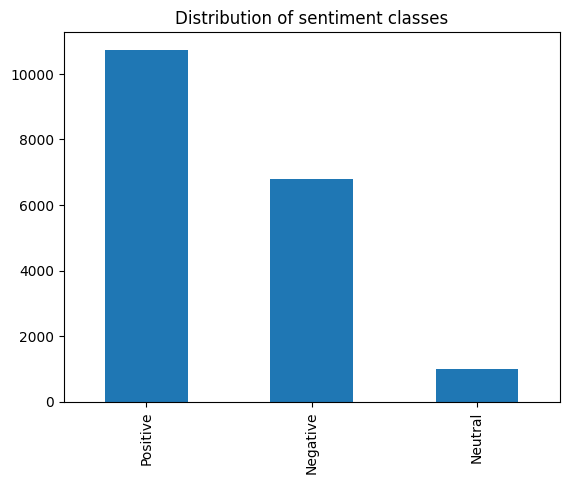

In [34]:
ax = df_senti['sentiment_class'].value_counts().plot(kind='bar')
ax.set_title('Distribution of sentiment classes')


In [8]:
# Save sentiment of articles to csv
df_senti.to_csv("data/articles_sentiment.csv")

## Fitting BERTopic

This might take a while on a CPU. In the background a pre-trained Large Language Model, called the sentence embedder, is used to convert the articles to a semantic vector space. We then perform clustering in this space.

In [9]:
if os.path.exists('southsudan_model'):
    bertopic = BERTopic.load('southsudan_model')
else:
    bertopic = BERTopic(language="english", calculate_probabilities=True, verbose=True) # Initialize the BERTopic model

    bertopic.fit_transform(docs) # Fit the model to the list of article summaries
    bertopic.save("southsudan_model") # Save the trained model as "southsudan_model"

Batches: 100%|██████████| 579/579 [13:14<00:00,  1.37s/it]
2023-10-03 16:57:37,404 - BERTopic - Transformed documents to Embeddings
2023-10-03 16:58:11,492 - BERTopic - Reduced dimensionality
2023-10-03 16:59:37,254 - BERTopic - Clustered reduced embeddings


In [10]:
#Due to the modularity of the model, there is a lot of randomness that hinders reproducibiity of the model.
#To fight this, you can for example set random state in the dimensionality reduction step via the following lines 
#or explore a different approach

#from bertopic import BERTopic
#from umap import UMAP

#umap_model = UMAP(n_neighbors=15, n_components=5, 
#                  min_dist=0.0, metric='cosine', random_state=42)
#topic_model = BERTopic(umap_model=umap_model)

## Interactive visualization of the vector space

As you can see, documents with related topics are close in the space.

In [11]:
# bertopic.visualize_documents(docs) # Create a plot of the topics, this may take a while

### Creating smaller topics

Within our list of topics, we find topics that are semantically closest to 4 keywords:

"Hunger", "Refugees", "Conflict", and "Humanitarian".

**Feel free to change this approach!**

In [12]:
# We create a function to calculate a list of the top n topics related to (a) given keyword(s)

def get_relevant_topics(bertopic_model, keywords, top_n):
    '''
    Retrieve a list of the top n number of relevant topics to the provided (list of) keyword(s)
    
    
    Parameters:
        bertopic_model: a (fitted) BERTopic model object
        
        keywords:   a string containing one or multiple keywords to match against,
                    
                    This can also be a list in the form of ['keyword(s)', keyword(s), ...]
                    
                    In this case a maximum of top_n topics will be found per list element 
                    and subsetted to the top_n most relevant topics.
                    
                    !!!
                    Take care that this method only considers the relevancy per inputted keyword(s) 
                    and not the relevancy to the combined list of keywords.
                    
                    In other words, topics that appear in the output might be significantly related to a 
                    particular element in the list of keywords but not so to any other element, 
                    
                    while topics that do not appear in the output might be significantly related to the 
                    combined list of keywords but not much to any of the keyword(s) in particular.
                    !!!
                    
        top_n: an integer indicating the number of desired relevant topics to be retrieved
        
        
        Return: a list of the top_n (or less) topics most relevant to the (list of) provided keyword(s)
    '''
    
    if type(keywords) is str: keywords = [keywords] # If a single string is provided convert it to list type
    
    relevant_topics = list() # Initilize an empty list of relevant topics
    
    for keyword in keywords: # Iterate through list of keywords
        
        # Find the top n number of topics related to the current keyword(s)
        topics = bertopic_model.find_topics(keyword, top_n = top_n)
        
        # Add the topics to the list of relevant topics in the form of (topic_id, relevancy)
        relevant_topics.extend(
            zip(topics[0], topics[1]) # topics[0] = topic_id, topics[1] = relevancy
        )
    
    
    relevant_topics.sort(key=lambda x: x[1]) # Sort the list of topics on ASCENDING ORDER of relevancy
    
    # Get a list of the set of unique topics (with greates relevancy in case of duplicate topics)
    relevant_topics = list(dict(relevant_topics).items())
    
    
    relevant_topics.sort(key=lambda x: x[1], reverse=True) # Now sort the list of topics on DESCENDING ORDER of relevancy
    
    return relevant_topics[:10] # Return a list of the top_n unique relevant topics

In [13]:
# Get the top 10 topics related to the keywords 'hunger' and 'food insecurity'
relevant_topics = get_relevant_topics(bertopic_model = bertopic, keywords=['hunger', 'food insecurity'], top_n=10)

topic_ids = [el[0] for el in relevant_topics] # Create seperate list of topic IDs

for topic_id, relevancy in relevant_topics: # Print neat list of (topic_id, relevancy) tuples
    print(topic_id, relevancy)
    
df["hunger"] = [t in topic_ids for t in bertopic.topics_] # Add boolean column to df if topic in list of relevant topics

# View the Count, Name, Representation, and Representative Docs for the relevant topics
bertopic.get_topic_info().set_index('Topic').loc[topic_ids]

18 0.506673
119 0.4540154
120 0.45238495
63 0.44405204
234 0.4301224
27 0.3522862
136 0.3129899
129 0.3071161
164 0.28995687
158 0.28540993


,Count,Name,Representation,Representative_Docs
Topic,,,,
18,111,18_food_hunger_famine_million,"[food, hunger, famine, million, crisis, insecu...",[The article discusses how millions of people ...
119,31,119_malnutrition_children_nutrition_unicef,"[malnutrition, children, nutrition, unicef, br...",[The article discusses the high rates of acute...
120,31,120_fao_food_kits_seeds,"[fao, food, kits, seeds, livelihood, million, ...",[The article discusses the funding shortfall f...
63,54,63_wfp_food_programme_assistance,"[wfp, food, programme, assistance, world, mill...",[The article discusses Australia's AUD 1.25 mi...
234,13,234_wfp_airdrops_food_maban,"[wfp, airdrops, food, maban, yida, drops, metr...",[The article discusses the United Nations Worl...
27,98,27_agriculture_agricultural_food_farmers,"[agriculture, agricultural, food, farmers, far...",[The article discusses the need for cooperatio...
136,26,136_tons_wfp_metric_food,"[tons, wfp, metric, food, refugees, humanitari...",[The article discusses the successful delivery...
129,28,129_children_unicef_boys_recruited,"[children, unicef, boys, recruited, lost, educ...",[The article discusses the warning from the UN...
164,21,164_prices_price_inflation_poverty,"[prices, price, inflation, poverty, beverages,...",[The article discusses the impact of spiraling...


In [14]:
# Get the top 10 topics related to the keywords 'refugees' and 'displaced'
relevant_topics = get_relevant_topics(bertopic_model = bertopic, keywords=['refugees', 'displaced'], top_n=10)

topic_ids = [el[0] for el in relevant_topics] # Create seperate list of topic IDs

for topic_id, relevancy in relevant_topics: # Print neat list of (topic_id, relevancy) tuples
    print(topic_id, relevancy)
    
df["refugees"] = [t in topic_ids for t in bertopic.topics_] # Add boolean column to df if topic in list of relevant topics

# View the Count, Name, Representation, and Representative Docs for the relevant topics
bertopic.get_topic_info().set_index('Topic').loc[topic_ids]

16 0.6879362
10 0.65165806
249 0.64660645
130 0.6259512
114 0.62380624
45 0.57727206
173 0.5238633
65 0.5126127
44 0.51150966
133 0.50898457


,Count,Name,Representation,Representative_Docs
Topic,,,,
16,121,16_refugees_uganda_refugee_district,"[refugees, uganda, refugee, district, adjumani...",[The article discusses the launch of a regiona...
10,148,10_refugees_unhcr_yida_refugee,"[refugees, unhcr, yida, refugee, nile, camp, c...",[The article discusses the acute malnutrition ...
249,11,249_israeli_israel_migrants_immigrants,"[israeli, israel, migrants, immigrants, asylum...",[The article discusses an incident where Egypt...
130,27,130_kakuma_refugee_camp_kenya,"[kakuma, refugee, camp, kenya, refugees, camps...",[The article discusses the influx of refugees ...
114,33,114_refugees_unhcr_funding_refugee,"[refugees, unhcr, funding, refugee, million, a...",[The article discusses the UNHCR's appeal for ...
45,73,45_displaced_idps_internally_people,"[displaced, idps, internally, people, bases, p...",[The article discusses the high number of inte...
173,19,173_civilians_un_unmiss_displaced,"[civilians, un, unmiss, displaced, bases, refu...",[The article discusses new fighting in South S...
65,52,65_darfur_unamid_darfuri_300000,"[darfur, unamid, darfuri, 300000, chad, displa...",[The article discusses a news report by the Ne...
44,75,44_returnees_kosti_iom_repatriation,"[returnees, kosti, iom, repatriation, stranded...",[The article discusses the expected arrival of...


In [15]:
# Get the top 10 topics related to the keyword 'humanitarian'
relevant_topics = get_relevant_topics(bertopic_model = bertopic, keywords=['humanitarian'], top_n=10)

topic_ids = [el[0] for el in relevant_topics] # Create seperate list of topic IDs

for topic_id, relevancy in relevant_topics: # Print neat list of (topic_id, relevancy) tuples
    print(topic_id, relevancy)
    
df["humanitarian"] = [t in topic_ids for t in bertopic.topics_] # Add boolean column to df if topic in list of relevant topics

# View the Count, Name, Representation, and Representative Docs for the relevant topics
bertopic.get_topic_info().set_index('Topic').loc[topic_ids]

205 0.6632353
99 0.64624465
24 0.63671637
208 0.63332987
114 0.61188877
53 0.6077286
192 0.6024331
45 0.5974747
173 0.5964465
129 0.58958066


,Count,Name,Representation,Representative_Docs
Topic,,,,
205,15,205_humanitarian_aid_egeland_relief,"[humanitarian, aid, egeland, relief, assistanc...",[The article discusses the political and human...
99,38,99_humanitarian_jonglei_pibor_amos,"[humanitarian, jonglei, pibor, amos, affected,...",[The article discusses the worsening situation...
24,104,24_million_humanitarian_aid_assistance,"[million, humanitarian, aid, assistance, fundi...",[The article discusses the United States' anno...
208,15,208_lanzer_toby_coordinator_humanitarian,"[lanzer, toby, coordinator, humanitarian, mr, ...",[The article discusses a press briefing with t...
114,33,114_refugees_unhcr_funding_refugee,"[refugees, unhcr, funding, refugee, million, a...",[The article discusses the UNHCR's appeal for ...
53,62,53_workers_aid_humanitarian_worker,"[workers, aid, humanitarian, worker, killing, ...",[The article discusses the disappearance of si...
192,17,192_eu_european_commissions_million,"[eu, european, commissions, million, humanitar...",[The article discusses the European Union's fi...
45,73,45_displaced_idps_internally_people,"[displaced, idps, internally, people, bases, p...",[The article discusses the high number of inte...
173,19,173_civilians_un_unmiss_displaced,"[civilians, un, unmiss, displaced, bases, refu...",[The article discusses new fighting in South S...


In [16]:
# Get the top 10 topics related to the keywords 'conflict', 'fighting', and 'murder'
relevant_topics = get_relevant_topics(bertopic_model = bertopic, keywords=['conflict', 'fighting', 'murder'], top_n=10)

topic_ids = [el[0] for el in relevant_topics] # Create seperate list of topic IDs

for topic_id, relevancy in relevant_topics: # Print neat list of (topic_id, relevancy) tuples
    print(topic_id, relevancy)
    
df["conflict"] = [t in topic_ids for t in bertopic.topics_] # Add boolean column to df if topic in list of relevant topics

# View the Count, Name, Representation, and Representative Docs for the relevant topics
bertopic.get_topic_info().set_index('Topic').loc[topic_ids]

230 0.4187336
76 0.4134051
104 0.38569564
84 0.38415265
51 0.3829007
67 0.38082975
253 0.37851703
154 0.37832755
217 0.3750435
93 0.37361577


,Count,Name,Representation,Representative_Docs
Topic,,,,
230,13,230_nassir_upper_ceasefire_truce,"[nassir, upper, ceasefire, truce, positions, n...",[The article discusses accusations from the So...
76,46,76_kordofan_blue_border_darfur,"[kordofan, blue, border, darfur, both, negotia...",[The article discusses the condemnation by the...
104,36,104_talks_ababa_addis_peace,"[talks, ababa, addis, peace, ethiopia, round, ...",[The article discusses the second phase of pea...
84,43,84_jonglei_state_conference_communities,"[jonglei, state, conference, communities, peac...",[The article discusses Governor Kuol Manyang J...
51,66,51_wau_protests_western_bahr,"[wau, protests, western, bahr, ghazal, bagari,...","[The article discusses a meeting in Wau, the c..."
67,50,67_ethnic_conflict_machar_riek,"[ethnic, conflict, machar, riek, dinka, nuer, ...",[The article discusses the call from internall...
253,10,253_dinka_nuer_tribes_tribe,"[dinka, nuer, tribes, tribe, dinkas, author, f...",[The article discusses the crisis in South Sud...
154,22,154_ceasefire_signing_ababa_addis,"[ceasefire, signing, ababa, addis, agreement, ...",[The article discusses the signing of a cessat...
217,14,217_ethiopias_abiy_ethiopia_prime,"[ethiopias, abiy, ethiopia, prime, role, abiye...",[The article discusses Ethiopia's efforts to e...


In [17]:
# Combine article summaries with the newly created features and sentiment

df_senti_topic = pd.merge(df, df_senti[['summary', 'senti_score']], on = ['summary'])
df_senti_topic.to_csv("data/articles_senti_topics.csv", index=False) # Save DataFrame to articles_senti_topics.csv
df_senti_topic

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict,senti_score
0,The article discusses the passing of the new C...,2011-07-07,Juba,4.859363,31.571250,False,False,False,False,1.500
1,The article discusses the military actions tak...,2011-07-03,Abyei,9.838551,28.486396,False,False,False,False,-2.125
2,The article discusses the signing of a Framewo...,2011-06-30,Southern Kordofan,11.036544,30.895824,False,False,False,False,1.750
3,The article discusses the upcoming independenc...,2011-07-04,South Sudan,6.876992,31.306979,False,False,False,False,0.500
4,The article discusses the need for South Sudan...,2011-07-02,Juba,4.859363,31.571250,False,False,False,False,0.500
...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-26,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,4.750
18516,The article discusses the bombing and forced e...,2023-04-26,Khartoum,15.500654,32.559899,False,False,False,False,0.625
18517,The article discusses how Prime Minister Abiy ...,2023-04-23,Addis Ababa,8.980603,38.757761,False,False,False,True,0.750
18518,The article discusses the collapse of a commer...,2023-04-17,Kampala International University,0.294360,32.603970,False,False,False,True,-0.875


In [18]:
print(len(df))
print(len(df[(df["hunger"]==False) & (df["refugees"] == False) & (df["humanitarian"] == False) & (df["conflict"] == False)]))

18520
16909


There are a lot of articles that do not get sorted into either of the categories. So, feel free to change or expand this approach!